# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [2]:
import numpy as np
from scipy import optimize
import sympy as sm
from sympy import Symbol
from sympy.solvers import solve
sm.init_printing(use_unicode=True) # for pretty printing
from IPython.display import display
import matplotlib.pyplot as plt # baseline modul
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject


# Model description

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

## Numerical solution

We now progress to the numerical solution to the Solow-Swan-model with human capital accumulation


In [28]:
#For our numerical solution we use the following baseline parameters

s_h = 0.1
s_k = 0.1
g = 0.02
n = 0.01
alpha = 1/3
phi = 1/3
delta = 0.06

In [30]:
def f(h,k,s_h,s_k,g,n,alpha,phi,delta):
    """input arguments:
    h     (float): Human capital per effective worker (Stock)
    k     (float): Physical capital per effective worker (Stock)
    s_h   (float): Savings/Investments in human capital
    s_k   (float): Savings/Investments in physical capital
    g     (float): Growth rate of technology
    n     (float): Growth rate of labour force
    delta (float): Depreciation rate of physical capital
    alpha (float): Return on physical capital
    phi   (float): Return on human capital
    
    Returns: 
    The transition equation for human and physical capital per effective worker in steady state
    """

    h_function = 1/((1+n)*(1+g))*(s_h*k**(alpha)*h**(phi)+(1-delta)*h)-h
    k_function = 1/((1+n)*(1+g))*(s_k*k**(alpha)*h**(phi)+(1-delta)*k)-k
    return h_function,k_function

# Setting up the objective and solving the model
objective = lambda x: [f(x[0],x[1],s_h,s_k,g,n,alpha,phi,delta)]
sol = optimize.root(objective,[1,1],method = 'broyden1')
num_sol = sol.x

print(f'The level of human and physical capital per effective worker in steady state is = {num_sol[0]:.3f} and {num_sol[1]:.3f}, respectively.')


The level of human and physical capital per effective worker in steady state is = 1.363 and 1.363, respectively.


The phase-diagram can be used to illustrate that there only exist a single point where both human and physical capital per effective worker is constant, which is characterized as our steady state:

$\Delta\tilde{h}^{\ast}=\Delta\tilde{k}^{\ast}=0$ 


The phase-diagram consists of two nullclines where $\Delta\tilde{h}^{\ast}=0$ and $\Delta\tilde{k}^{\ast}=0$, repsectively.

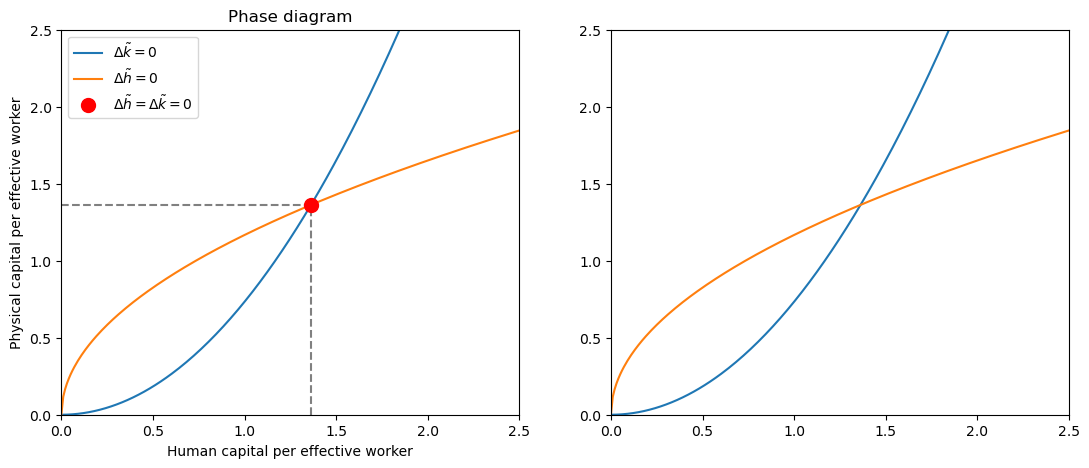

In [55]:
def solve_steadystate(s_h,s_k,g,n,alpha,phi,delta):
    """input arguments:
    s_h   (float): Savings/Investments in human capital
    s_k   (float): Savings/Investments in physical capital
    g     (float): Growth rate of technology
    n     (float): Growth rate of labour force
    alpha (float): Return on physical capital
    phi   (float): Return on human capital
    delta (float): Depriciation rate of physical capital
    
    Returns:
    The nullclines for physical and human capital, respectively
    """
    
    # a. Setting up the grid
    grid_space = np.linspace(1e-5,2.5,250)
    k_vector = np.empty(250)
    h_vector  = np.empty(250)
    
    # b. solve for each k in grid
    for i,k in enumerate(grid_space):
        #Solve for constant human capital
        
        # Objective and optimizer
        obj = lambda h: -h_function(k,s_h,s_k,g,n,alpha,phi,delta,h)
        result = optimize.root_scalar(obj,method='brentq',bracket=[1e-20,50])
        h_vector[i] = result.root

        #Solve for constant physical capital

        # Objective and optimizer
        obj = lambda h: -k_function(h,s_h,s_k,g,n,alpha,phi,delta,k)
        result = optimize.root_scalar(obj,method='brentq',bracket=[1e-20,50])
        k_vector[i] = result.root

    return grid_space, k_vector, h_vector


#Solve the function
grid_space, k_vector, h_vector = solve_steadystate(s_h,s_k,g,n,alpha,phi,delta)


#Create the plots
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1)
ax.plot(grid_space,k_vector, label=r'$\Delta \tilde{k}=0$')
ax.plot(grid_space,h_vector, label=r'$\Delta \tilde{h}=0$')


az = fig.add_subplot(1,2,2)
az.plot(grid_space,k_vector, label=r'$\Delta \tilde{k}=0$')
az.plot(grid_space,h_vector, label=r'$\Delta \tilde{h}=0$')


#Marking the steady state points
ax.scatter(sol.x[1],sol.x[0],color='red',s=100,zorder=3, label=r'$\Delta\tilde{h}=\Delta\tilde{k}=0$')

ax.axvline(sol.x[1],ymax=0.55,color='gray',linestyle='--') 
ax.axhline(sol.x[0],xmax=0.55,color='gray',linestyle='--')

#Legends
ax.set_xlabel(r'Human capital per effective worker')
ax.set_ylabel(r'Physical capital per effective worker')
ax.legend() 

#The axis values are chosen
ax.set(xlim=(0, 2.5), ylim=(0, 2.5))
az.set(xlim=(0, 2.5), ylim=(0, 2.5))

#Titles
ax.set_title('Base scenario');
az.set_title('Higher initial level of physical capital');

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 